In [39]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt

In [40]:
train_data = torchvision.datasets.MNIST(
    root='data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_data = torchvision.datasets.MNIST(
    root='data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

In [41]:
batch_size = 64

train_dataloader = DataLoader(dataset=train_data, batch_size=batch_size)
test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size)

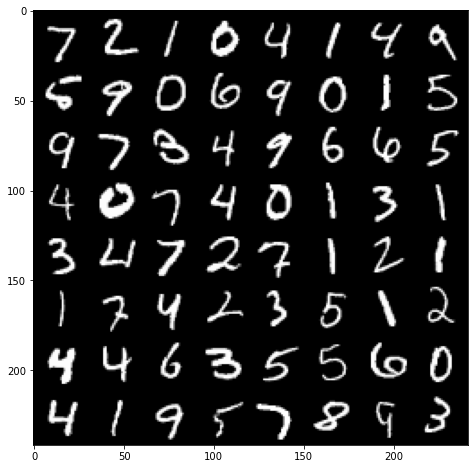

In [42]:
plt.figure(figsize=(8, 8))
iter_dataloader = iter(test_dataloader)
n=1

# 取出n*batch_size张图片可视化
for i in range(n):
    images, labels = next(iter_dataloader)
    image_grid = torchvision.utils.make_grid(images)
    plt.subplot(1, n, i+1)
    plt.imshow(np.transpose(image_grid.numpy(), (1, 2, 0)))

In [43]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [44]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet,self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,6,3,stride=1,padding=1),
            nn.MaxPool2d(2,2),
            nn.Conv2d(6,16,5,stride=1,padding=1),
            nn.MaxPool2d(2,2)
        )
        self.fc = nn.Sequential(
            nn.Linear(576,120),
            nn.Linear(120,84),
            nn.Linear(84,10)
        )
    def forward(self,x):
        out = self.conv(x)
        out = out.view(out.size(0),-1)
        out = self.fc(out)
        return out

network = LeNet()
network.cuda()

LeNet(
  (conv): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=576, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [45]:
len(train_data)

60000

In [46]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=network.parameters(), lr=0.001)

In [47]:
losses = []
iteration = 0

epochs = 200

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-----------------------------")
    for i, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        optimizer.zero_grad()

        pred = network(X)
        loss = loss_fn(pred, y)


        loss.backward()
        optimizer.step()

        if i % 200 == 0:
            losses.append(loss.item())
            iteration += 1
            print(f"loss: {loss.item():>7f}  [{(i+1)*len(X):>5d}/{len(train_dataloader.dataset):>5d}]")

Epoch 1
-----------------------------
loss: 2.294091  [   64/60000]
loss: 2.314866  [12864/60000]
loss: 2.301928  [25664/60000]
loss: 2.292557  [38464/60000]
loss: 2.291687  [51264/60000]
Epoch 2
-----------------------------
loss: 2.281990  [   64/60000]
loss: 2.297814  [12864/60000]
loss: 2.287441  [25664/60000]
loss: 2.271745  [38464/60000]
loss: 2.272274  [51264/60000]
Epoch 3
-----------------------------
loss: 2.263250  [   64/60000]
loss: 2.275451  [12864/60000]
loss: 2.263393  [25664/60000]
loss: 2.235826  [38464/60000]
loss: 2.234946  [51264/60000]
Epoch 4
-----------------------------
loss: 2.222814  [   64/60000]
loss: 2.228362  [12864/60000]
loss: 2.204574  [25664/60000]
loss: 2.139445  [38464/60000]
loss: 2.127893  [51264/60000]
Epoch 5
-----------------------------
loss: 2.095009  [   64/60000]
loss: 2.062941  [12864/60000]
loss: 1.975601  [25664/60000]
loss: 1.736549  [38464/60000]
loss: 1.690813  [51264/60000]
Epoch 6
-----------------------------
loss: 1.565890  [   64

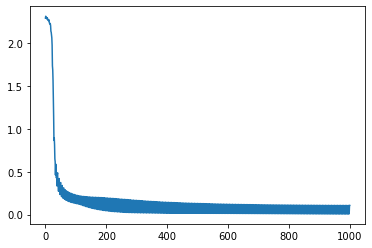

In [48]:
plt.plot(list(range(iteration)), losses)

In [49]:
torch.save(network.state_dict(), "model.pth")

In [50]:
network = LeNet()
network.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [53]:
positive = 0
negative = 0
for X, y in test_dataloader:
    with torch.no_grad():
        # X, y = X.to(device), y.to(device)
        pred = network(X)
        for item in zip(pred, y):
            if torch.argmax(item[0]) == item[1]:
                positive += 1
            else:
                negative += 1
acc = positive / (positive + negative)
print(f"{acc * 100}%")

98.53%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


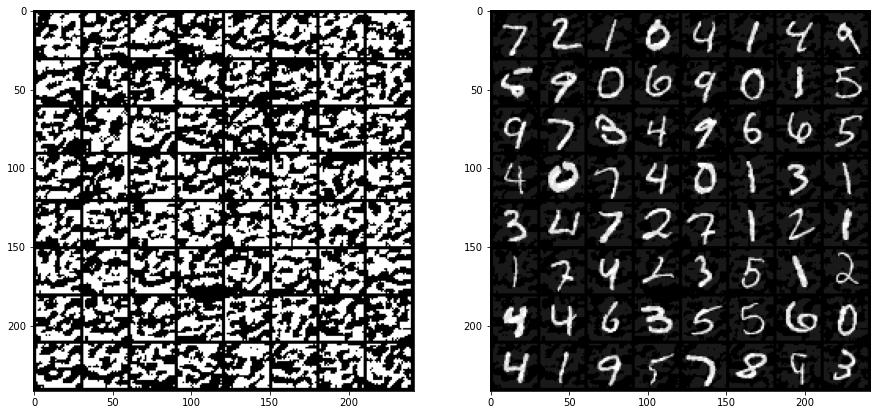

In [55]:
# 寻找对抗样本，并可视化
eps = 0.1
for X, y in test_dataloader:
    # X, y = X.to(device), y.to(device)

    X.requires_grad = True
    pred = network(X)
    network.zero_grad()
    loss = loss_fn(pred, y)
    loss.backward()

    plt.figure(figsize=(15, 8))

    plt.subplot(121)
    image_grid = torchvision.utils.make_grid(X.grad.sign())
    plt.imshow(np.transpose(image_grid.cpu().numpy(), (1, 2, 0)))

    X = X + eps * X.grad.sign()
    X_adv = torch.clamp(X, 0, 1)

    plt.subplot(122)
    image_grid = torchvision.utils.make_grid(X_adv)
    plt.imshow(np.transpose(image_grid.numpy(), (1, 2, 0)))

    break

In [62]:
# 用对抗样本替代原始样本，测试准确度

for X, y in test_dataloader:
    # X, y = X.to(device), y.to(device)

    X.requires_grad = True
    pred = network(X)
    network.zero_grad()
    loss = loss_fn(pred, y)
    loss.backward()

    X = X + eps * X.grad.sign()
    X_adv = torch.clamp(X, 0, 1)

    pred = network(X_adv)
    for item in zip(pred, y):
            if torch.argmax(item[0]) == item[1]:
                positive += 1
            else:
                negative += 1

acc = positive / (positive + negative)
print(f"{acc * 100}%")

59.09375%
